In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df23_x = pd.read_excel('./uprightdataset/df23/val_X.xls',header=None).iloc[1:,:]
df24_x = pd.read_excel('./uprightdataset/df24/val_X.xls',header=None).iloc[1:,:]
df25_x = pd.read_excel('./uprightdataset/df25/val_X.xls',header=None).iloc[1:,:]
df26_x = pd.read_excel('./uprightdataset/df26/val_X.xls',header=None).iloc[1:,:]
df27_x = pd.read_excel('./uprightdataset/df27/val_X.xls',header=None).iloc[1:,:]
df28_x = pd.read_excel('./uprightdataset/df28/val_X.xls',header=None).iloc[1:,:]
df29_x = pd.read_excel('./uprightdataset/df29/val_X.xls',header=None).iloc[1:,:]
df30_x = pd.read_excel('./uprightdataset/df30/val_X.xls',header=None).iloc[1:,:]

In [3]:
df23_f = pd.read_excel('./uprightdataset/df23/val_F.xls',header=None)
df24_f = pd.read_excel('./uprightdataset/df24/val_F.xls',header=None)
df25_f = pd.read_excel('./uprightdataset/df25/val_F.xls',header=None)
df26_f = pd.read_excel('./uprightdataset/df26/val_F.xls',header=None)
df27_f = pd.read_excel('./uprightdataset/df27/val_F.xls',header=None)
df28_f = pd.read_excel('./uprightdataset/df28/val_F.xls',header=None)
df29_f = pd.read_excel('./uprightdataset/df29/val_F.xls',header=None)
df30_f = pd.read_excel('./uprightdataset/df30/val_F.xls',header=None)

In [4]:
x = df23_x.append(df24_x).append(df25_x).append(df26_x).append(df27_x).append(df28_x).append(df29_x).append(df30_x)
x_renamed = x.rename(columns={0:"x",1:"theta1",2:"theta2",3:"v",4:"dtheta1",5:"dtheta2"})
x_renamed

,x,theta1,theta2,v,dtheta1,dtheta2
1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
246,6.818339e-15,6.283185,6.283185,3.175741e-14,-1.139458e-13,-3.477301e-14
247,7.801362e-15,6.283185,6.283185,2.099595e-14,-8.508598e-14,-3.191238e-14
248,7.972631e-15,6.283185,6.283185,-4.195826e-15,-2.251345e-14,-3.744042e-14
249,7.436722e-15,6.283185,6.283185,-1.809206e-14,1.199991e-14,-3.577486e-14


In [5]:
y= df23_f.append(df24_f).append(df25_f).append(df26_f).append(df27_f).append(df28_f).append(df29_f).append(df30_f)
y_renamed = y.rename(columns={0:"F"}).to_numpy()
y_renamed
y.shape

(2000, 1)

In [6]:
x_renamed['F'] = y_renamed

In [7]:
train, test = train_test_split(x_renamed, test_size=0.2, random_state=42, shuffle=True)

In [8]:
x_train = train[['x', 'theta1', 'theta2', 'v', 'dtheta1', 'dtheta2']]
y_train = train[['F']]

x_test = test[['x', 'theta1', 'theta2', 'v', 'dtheta1', 'dtheta2']]
y_test = test[['F']]

In [9]:
def init_weights(architecture):
    W = []
    b = []
    np.random.seed(1)
    hidden_layers = len(architecture)-1
    for i in range(hidden_layers):
        W.append(np.random.randn(architecture[i+1]).reshape(-1,1))
        b.append(np.zeros(architecture[i+1]).reshape(-1,1))
    return W,b

In [10]:
architecture = [6, 25, 25, 1]
W, b = init_weights(architecture)
W[0].shape

(25, 1)

In [11]:
x_renamed.mean()

x          2.169238
theta1     1.938283
theta2     1.815932
v          0.429826
dtheta1    0.070830
dtheta2    0.076904
F          0.025400
dtype: float64

In [12]:
from sklearn import preprocessing

In [19]:
input_scaler = preprocessing.StandardScaler().fit(x_train)
output_scaler = preprocessing.StandardScaler().fit(y_train)

print('Mean:')
print(input_scaler.transform(x_train).mean(axis=0))
print('Variance:')
print(input_scaler.transform(x_train).var(axis=0))

Mean:
[ 2.22044605e-17  7.54951657e-17 -1.33226763e-17  4.44089210e-18
 -1.77635684e-17  6.10622664e-18]
Variance:
[1. 1. 1. 1. 1. 1.]


In [16]:
def get_keras_model(architecture, activation='tanh'):
    inputs = keras.Input(shape=architecture[0], name='input')
    # Initiate list that will hold the output for layer i at element i. The first element is the input.
    layer_output = [inputs]
    
    for n_l in range(1, len(architecture)-1):
        layer_output.append(keras.layers.Dense(architecture[n_l], 
                                 activation=activation, 
                                 name='hidden_{}'.format(n_l))(layer_output[n_l-1]))
        
    layer_output.append(keras.layers.Dense(architecture[-1], name='output')(layer_output[-1]))
    
    model = tf.keras.Model(inputs=inputs, outputs=layer_output[-1])
    
    return model

In [61]:
architucture = [x_train.shape[1], 3, 3,3, y_train.shape[1]]

Imitation_model = get_keras_model(architucture)

Imitation_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 3)                 21        
_________________________________________________________________
hidden_2 (Dense)             (None, 3)                 12        
_________________________________________________________________
hidden_3 (Dense)             (None, 3)                 12        
_________________________________________________________________
output (Dense)               (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [62]:
Imitation_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MSE,
)

In [63]:
history = Imitation_model.fit(
    input_scaler.transform(x_train),
    output_scaler.transform(y_train),
    #batch_size=200,
    epochs = 500,
    verbose=1,
    validation_data=(input_scaler.transform(x_test), output_scaler.transform(y_test))
)

Epoch 1/500
50/50 [==============================] - 1s 4ms/step - loss: 0.9930 - val_loss: 0.9804
Epoch 2/500
50/50 [==============================] - 0s 2ms/step - loss: 0.9524 - val_loss: 0.9556
Epoch 3/500
50/50 [==============================] - 0s 1ms/step - loss: 0.9298 - val_loss: 0.9132
Epoch 4/500
50/50 [==============================] - 0s 1ms/step - loss: 0.9110 - val_loss: 0.9333
Epoch 5/500
50/50 [==============================] - 0s 1ms/step - loss: 0.9046 - val_loss: 0.9242
Epoch 6/500
50/50 [==============================] - 0s 1ms/step - loss: 0.8969 - val_loss: 0.9644
Epoch 7/500
50/50 [==============================] - 0s 1ms/step - loss: 0.9004 - val_loss: 0.9201
Epoch 8/500
50/50 [==============================] - 0s 1ms/step - loss: 0.8886 - val_loss: 0.9375
Epoch 9/500
50/50 [==============================] - 0s 1ms/step - loss: 0.8820 - val_loss: 0.9304
Epoch 10/500
50/50 [==============================] - 0s 1ms/step - loss: 0.8797 - val_loss: 0.9181
Epoch 11/

50/50 [==============================] - 0s 1ms/step - loss: 0.7134 - val_loss: 0.8054
Epoch 84/500
50/50 [==============================] - 0s 1ms/step - loss: 0.7153 - val_loss: 0.7842
Epoch 85/500
50/50 [==============================] - 0s 2ms/step - loss: 0.7082 - val_loss: 0.8092
Epoch 86/500
50/50 [==============================] - 0s 2ms/step - loss: 0.6977 - val_loss: 0.7954
Epoch 87/500
50/50 [==============================] - 0s 1ms/step - loss: 0.7113 - val_loss: 0.8218
Epoch 88/500
50/50 [==============================] - 0s 2ms/step - loss: 0.7011 - val_loss: 0.8066
Epoch 89/500
50/50 [==============================] - 0s 1ms/step - loss: 0.7011 - val_loss: 0.8329
Epoch 90/500
50/50 [==============================] - 0s 2ms/step - loss: 0.7167 - val_loss: 0.7989
Epoch 91/500
50/50 [==============================] - 0s 2ms/step - loss: 0.6959 - val_loss: 0.8427
Epoch 92/500
50/50 [==============================] - 0s 2ms/step - loss: 0.6989 - val_loss: 0.7994
Epoch 93/500


50/50 [==============================] - 0s 1ms/step - loss: 0.6690 - val_loss: 0.7753
Epoch 165/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6645 - val_loss: 0.7441
Epoch 166/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6819 - val_loss: 0.7636
Epoch 167/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6738 - val_loss: 0.7712
Epoch 168/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6770 - val_loss: 0.7448
Epoch 169/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6640 - val_loss: 0.7436
Epoch 170/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6808 - val_loss: 0.7531
Epoch 171/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6673 - val_loss: 0.7490
Epoch 172/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6701 - val_loss: 0.7571
Epoch 173/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6627 - val_loss: 0.7532
Epoc

50/50 [==============================] - 0s 1ms/step - loss: 0.6609 - val_loss: 0.7273
Epoch 246/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6713 - val_loss: 0.7471
Epoch 247/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6802 - val_loss: 0.7188
Epoch 248/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6834 - val_loss: 0.7622
Epoch 249/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6511 - val_loss: 0.7464
Epoch 250/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6560 - val_loss: 0.7249
Epoch 251/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6602 - val_loss: 0.7266
Epoch 252/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6679 - val_loss: 0.7090
Epoch 253/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6606 - val_loss: 0.7433
Epoch 254/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6590 - val_loss: 0.7295
Epoc

50/50 [==============================] - 0s 1ms/step - loss: 0.6487 - val_loss: 0.7490
Epoch 327/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6497 - val_loss: 0.7057
Epoch 328/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6590 - val_loss: 0.7352
Epoch 329/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6561 - val_loss: 0.7663
Epoch 330/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6603 - val_loss: 0.7154
Epoch 331/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6479 - val_loss: 0.7799
Epoch 332/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6463 - val_loss: 0.7448
Epoch 333/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6557 - val_loss: 0.6924
Epoch 334/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6662 - val_loss: 0.7240
Epoch 335/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6407 - val_loss: 0.6996
Epoc

50/50 [==============================] - 0s 1ms/step - loss: 0.6437 - val_loss: 0.7031
Epoch 408/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6578 - val_loss: 0.7037
Epoch 409/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6466 - val_loss: 0.7190
Epoch 410/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6434 - val_loss: 0.7588
Epoch 411/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6551 - val_loss: 0.7188
Epoch 412/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6380 - val_loss: 0.7455
Epoch 413/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6384 - val_loss: 0.7031
Epoch 414/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6436 - val_loss: 0.7064
Epoch 415/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6388 - val_loss: 0.7474
Epoch 416/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6376 - val_loss: 0.7146
Epoc

50/50 [==============================] - 0s 1ms/step - loss: 0.6300 - val_loss: 0.7228
Epoch 489/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6352 - val_loss: 0.6945
Epoch 490/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6353 - val_loss: 0.6909
Epoch 491/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6412 - val_loss: 0.6936
Epoch 492/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6533 - val_loss: 0.6941
Epoch 493/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6352 - val_loss: 0.7051
Epoch 494/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6320 - val_loss: 0.6936
Epoch 495/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6432 - val_loss: 0.7149
Epoch 496/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6362 - val_loss: 0.6993
Epoch 497/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6337 - val_loss: 0.7025
Epoc

In [64]:
y_hat_scaled = Imitation_model.predict(input_scaler.transform(x_test))
y_hat = output_scaler.inverse_transform(y_hat_scaled)

sklearn.metrics.r2_score(y_hat_scaled, output_scaler.transform(y_test))

-0.7630532786824107

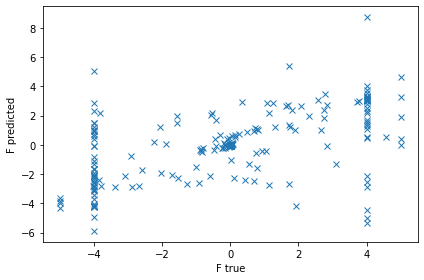

In [29]:
fig, ax = plt.subplots(1)


ax.plot(y_test['F'], y_hat[:,0],'x')
#ax[1].plot(y_test['NOX'], y_hat[:,1],'x')

ax.set_xlabel('F true')
ax.set_ylabel('F predicted')

#ax[1].set_xlabel('NOx true')
#ax[1].set_ylabel('NOx predicted')


fig.tight_layout()

In [227]:
#Save scaled_model to file
Imitation_model.save("Imitation_model",'./')

INFO:tensorflow:Assets written to: Imitation_model\assets


In [228]:
from keras.models import model_from_json
# serialize model to JSON
gt_model_json = gt_model.to_json()
with open("Imitation_model.json", "w") as json_file:
    json_file.write(gt_model_json)
# serialize weights to HDF5
gt_model.save_weights("Imitation_model.h5")
print("Saved model to disk")

Saved model to disk


In [229]:
# load json and create model for scaled variant
json_file = open('Imitation_model.json', 'r')
gt_loaded_model_json = json_file.read()
json_file.close()
gt_loaded_model = model_from_json(gt_loaded_model_json)
# load weights into new model
gt_loaded_model.load_weights("Imitation_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [230]:
x0 = pd.DataFrame([0.0,np.pi,np.pi,0.0,0.0,0.0])
print(x0)
prediction = gt_loaded_model.predict(x0.T)
print(prediction)

          0
0  0.000000
1  3.141593
2  3.141593
3  0.000000
4  0.000000
5  0.000000
[[1.1704065]]
